In [7]:
import numpy as np
import matplotlib.pyplot as plt
from graph_tools import Graph
import networkx as nx
import random
import copy
import time
import json

import ldpc
import bposd

from bposd.css_decode_sim import css_decode_sim
from bposd.hgp import hgp
import pickle

import multiprocessing as mp
import random
from ldpc import bp_decoder
from bposd import bposd_decoder
from bposd.css import css_code
from ldpc.codes import ring_code


plt.style.use('/Users/qian/Documents/Python/PaperDoubleFig.mplstyle')

from scipy.optimize import curve_fit
import stim

import sys
sys.path.append("/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/src/")
from Decoders import BPOSD_Decoder, FirstMinBPDecoder, BPDecoder

sys.path.append("/Users/qian/Box Sync/Research/Jiang_group_projects/Squeezed_Cats_Synchronized/Squeezed_Cat/Codes/src/")
from ErrorPlugin import *
from Simulators import *

In [8]:
def CriticalExponentFit(xdata_tuple, pc, nu, A, B, C):
    p, d = xdata_tuple
    x = (p - pc)*d**(1/nu)
    pl = A + B*x + C*x**2
    return pl

def EmpericalFit(xdata_tuple, pc, A):
    p, d = xdata_tuple
    pl = A*(p/pc)**(d/2)
    return pl

def FitDistance(logp, A, d):
    logpl = A + (d/2)*logp
    return logpl

In [48]:
def ThresholdEst(sweep_p_list, sweep_pl_total_list, if_plot=False):
#     sweep_p_list = []
#     sweep_pl_list = []
    num_p = len(sweep_p_list)
    num_code = len(sweep_pl_total_list)
    sweep_d_list = []
    for sweep_pl_list in sweep_pl_total_list:
        initial_guess = (0.08, 3)
        popt, pcov = curve_fit(FitDistance, np.log10(np.array(sweep_p_list)), np.log10(np.array(sweep_pl_list) + 1e-10), p0=initial_guess)
        sweep_d_list.append(popt[1])
    
    fit_d_list = copy.deepcopy(sweep_d_list)
    sweep_p_list = list(sweep_p_list)*num_code
    sweep_d1_list = []
    for sweep_d in sweep_d_list:
        sweep_d1_list += [sweep_d]*num_p
    sweep_d_list = sweep_d1_list
    sweep_pl_list = list(np.reshape(np.array(sweep_pl_total_list) + 1e-10, [num_p*num_code, ]))
    
    fit_X = np.vstack([np.reshape(np.array(sweep_p_list), [1, num_p*num_code]), 
                       np.reshape(np.array(sweep_d_list), [1, num_p*num_code])])
    fit_Z = np.reshape(np.array(sweep_pl_total_list), [num_p*num_code, ])
    initial_guess = (0.04, 0.1)
    popt, pcov = curve_fit(EmpericalFit, fit_X, fit_Z, p0=initial_guess)
    perr = np.sqrt(np.diag(pcov))
    
    # plot
    p_c, A = popt[0], popt[1]
#     fit_d_list = list(set(sweep_d_list))
    fit_p_list = list(set(sweep_p_list))
    fit_pl_list = np.reshape(np.array(sweep_pl_list), [len(fit_d_list), len(fit_p_list)])
    if if_plot:
        fitted_pl_list = []
        for sweep_d in fit_d_list:
            fitted_pl_list.append([EmpericalFit((sweep_p, sweep_d), p_c, A) for sweep_p in fit_p_list])
        
        plt.figure()
        for i in range(len(fit_d_list)):
#             plt.plot(fit_p_list, fit_pl_list[i], '+')
            plt.plot(fit_p_list, fitted_pl_list[i], '-', c = 'C%i'%i)
            plt.plot(sweep_p_list[:num_p], sweep_pl_list[i*num_p:(i + 1)*num_p], 'D', c = 'C%i'%i)
        #plt.scatter(sweep_p_list, sweep_pl_list[i*num_p:(i + 1)*num_p])
        plt.xscale('log')
        plt.yscale('log')
    
    print('A:', popt[1], 'p_c:', popt[0])
    
    return popt[0]

In [49]:
def CodeFamilyPhenlThreshold(eval_code_list, eval_p_list, num_rounds, num_samples, if_plot=False):
    eval_wer_list = []
    start_time = time.time()
    for eval_code in eval_code_list:
        for eval_p in eval_p_list:
            pauli_error_probs = [eval_p/3, eval_p/3, eval_p/3]

            eval_hx_extended = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
            eval_hz_extended = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

            dec1_x = BPDecoder(h= eval_hz_extended,
                                       channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(np.shape(eval_hz_extended)[1]),
                                        max_iter=int(eval_code.N/40), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625)

            dec1_z = BPDecoder(h=eval_hx_extended,
                                       channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(np.shape(eval_hx_extended)[1]),
                                        max_iter=int(eval_code.N/40), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625)

            dec2_x = BPOSD_Decoder(h=eval_code.hz, channel_probs=(pauli_error_probs[0] + pauli_error_probs[1])*np.ones(eval_code.N),
                                        max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625, osd_method="osd_e",
                                        osd_order = 10)
            dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=(pauli_error_probs[1] + pauli_error_probs[2])*np.ones(eval_code.N),
                                        max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625, osd_method="osd_e",
                                        osd_order = 10)

            code_simulator = CodeSimulator_Phenon(code=eval_code, decoder1_x= dec1_x, decoder1_z= dec1_z,
                                                  decoder2_x=dec2_x, decoder2_z=dec2_z,
                                                  pauli_error_probs=pauli_error_probs)

            eval_wer_list.append(code_simulator.WordErrorRate(num_rounds=num_rounds, num_samples=num_samples)[0])

    eval_wer_array = np.reshape(np.array(eval_wer_list), [len(eval_code_list), len(eval_p_list)])

    end_time = time.time()
    print('Time elapsed:', end_time - start_time)
    
    return ThresholdEst(eval_p_list, eval_wer_array, if_plot)

In [57]:
def CodeFamilyCircuitThreshold(eval_code_list, eval_p_list, num_rounds, num_samples, if_plot=False):
    eval_wer_list = []
    num_cycles = num_rounds
    start_time = time.time()
    for eval_code in eval_code_list:
        for eval_p in eval_p_list:
            p = eval_p
            p_idling_gate = 0
            error_params = {"p_i": 0, "p_state_p": 0, "p_m": 0, "p_CX":1*p, "p_idling_gate": p_idling_gate}

    #         p_data = 6*(8/15)*pz + pz
            p_data = 3*6*(8/15)*p 
            p_synd = 7*(8/15)*p

            eval_hx_ext = np.hstack([eval_code.hx, np.identity(np.shape(eval_code.hx)[0])])
            eval_hz_ext = np.hstack([eval_code.hz, np.identity(np.shape(eval_code.hz)[0])])

            dec1_z = BPDecoder(h=eval_hx_ext,
                                       channel_probs=np.hstack([p_data*np.ones(np.shape(eval_code.hx)[1]), p_synd*np.ones(np.shape(eval_code.hx)[0])]),
                                        max_iter=int(eval_code.N/30), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625)

            dec2_z = BPOSD_Decoder(h=eval_code.hx, channel_probs=p*np.ones(eval_code.N),
                                        max_iter=int(eval_code.N/10), bp_method="minimum_sum",
                                        ms_scaling_factor=0.625, osd_method="osd_e",
                                        osd_order = 10)

            code_simulator_circuit = CodeSimulator_Circuit(code=eval_code, decoder1_z= dec1_z,
                                                  decoder2_z=dec2_z, pz=p, num_cycles=num_cycles, 
                                                  error_params=error_params)
            code_simulator_circuit._generate_circuit()
            eval_wer_list.append(code_simulator_circuit.WordErrorRate(num_samples=num_samples)[0])

    end_time = time.time()
    print('Time elapsed:', end_time - start_time)

    eval_wer_array = np.reshape(np.array(eval_wer_list), [len(eval_code_list), len(eval_p_list)])
    
    return ThresholdEst(eval_p_list, eval_wer_array, if_plot)

# Load the codes

In [ ]:
# Load the HGP code - (3,7)
hgp_n225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n225.pkl')
# hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625.pkl')
hgp_n625 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n625_q1.pkl')
hgp_n1225 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1225_q3.pkl')
hgp_n1600 = load_object('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/codes_lib/hgp_34_n1600.pkl')

print('code params1:', hgp_n225.N, hgp_n225.K)
print('code params2:', hgp_n625.N, hgp_n625.K)
print('code params3:', hgp_n1225.N, hgp_n1225.K)
print('code params4:', hgp_n1600.N, hgp_n1600.K)

In [ ]:
# Load the LP codes - (3,8)
from scipy.io import loadmat
LP_code1_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L16_Dmin12_hx.mat')['LP_Matg8_L16_Dmin12_hx']
LP_code1_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L16_Dmin12_hz.mat')['LP_Matg8_L16_Dmin12_hz']
LP_code2_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L21_Dmin16_hx.mat')['LP_Matg8_L21_Dmin16_hx']
LP_code2_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L21_Dmin16_hz.mat')['LP_Matg8_L21_Dmin16_hz']
LP_code3_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L30_Dmin20_hx.mat')['LP_Matg8_L30_Dmin20_hx']
LP_code3_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/LP_Matg8_L30_Dmin20_hz.mat')['LP_Matg8_L30_Dmin20_hz']

LP_code1 = css_code(hx=LP_code1_hx,hz=LP_code1_hz)
LP_code2 = css_code(hx=LP_code2_hx,hz=LP_code2_hz)
LP_code3 = css_code(hx=LP_code3_hx,hz=LP_code3_hz)

print('code params1:', LP_code1.N, LP_code1.K)
print('code params2:', LP_code2.N, LP_code2.K)
print('code params3:', LP_code3.N, LP_code3.K)

In [ ]:
# Load the generalized bicycle codes (GBC) - (3,6) 
from scipy.io import loadmat
GBC_code1_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA1_hx.mat')['GenBicycleCodeATh1_hx']
GBC_code1_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA1_hz.mat')['GenBicycleCodeATh1_hz']
GBC_code2_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA2_hx.mat')['GenBicycleCodeATh2_hx']
GBC_code2_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA2_hz.mat')['GenBicycleCodeATh2_hz']
GBC_code3_hx = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA3_hx.mat')['GenBicycleCodeATh3_hx']
GBC_code3_hz = loadmat('/Users/qian/Box Sync/Research/Jiang_group_projects/QLDPC/HGP_Simulations/codes_lib/GenBicycleA3_hz.mat')['GenBicycleCodeATh3_hz']

GBC_code1 = css_code(hx=GBC_code1_hx,hz=GBC_code1_hz)
GBC_code2 = css_code(hx=GBC_code2_hx,hz=GBC_code2_hz)
GBC_code3 = css_code(hx=GBC_code3_hx,hz=GBC_code3_hz)

print('code params1:', GBC_code1.N, GBC_code1.K)
print('code params2:', GBC_code2.N, GBC_code2.K)
print('code params3:', GBC_code3.N, GBC_code3.K)

# Phenomenological threshold

## HGP codes

In [38]:
# eval_code_list = [hgp_n225, hgp_n625, hgp_n1225]
# eval_p_list = np.linspace(2e-2, 4e-2, 4)
# num_rounds = 5
# num_samples = 600

# CodeFamilyThreshold(eval_code_list, eval_p_list, num_rounds, num_samples, if_plot=True)

Time elapsed: 108.13438606262207
A: 0.5872119115873659 p_c: 0.15621568133421057
Time elapsed: 96.67989468574524
A: 0.09315094168319102 p_c: 0.06867890717924627
Time elapsed: 102.16855502128601
A: 0.0750927569479817 p_c: 0.06252236520770386
Time elapsed: 125.62408661842346
A: 0.12066351559463959 p_c: 0.03292680071781983


/Users/qian/anaconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


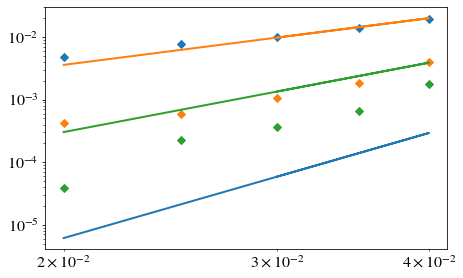

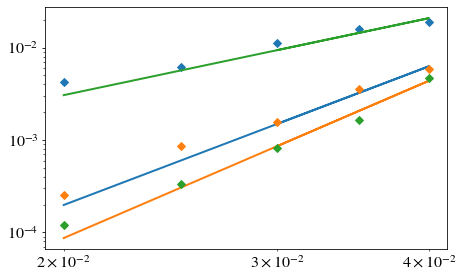

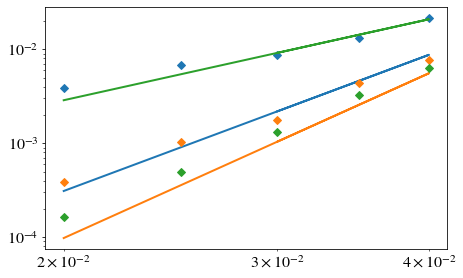

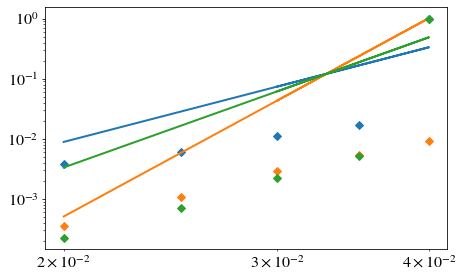

In [31]:
eval_code_list = [hgp_n225, hgp_n625, hgp_n1600]
eval_p_list = np.linspace(2e-2, 4e-2, 5)
num_samples = 800

sweep_num_round_list = [3, 6, 10, 15]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

Text(0.5, 1.0, 'HGP, Phenomenological noise')

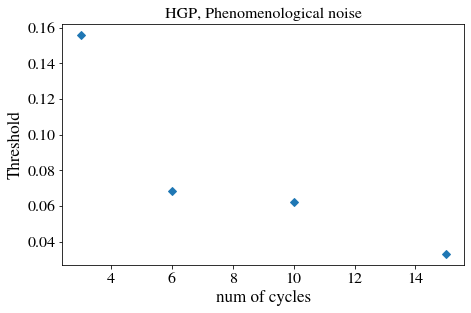

In [32]:
plt.figure()
plt.plot(sweep_num_round_list, sweep_threshold_list, 'D')
plt.xlabel('num of cycles')
plt.ylabel('Threshold')
plt.title('HGP, Phenomenological noise')

Time elapsed: 65.91781711578369
A: 0.05699943371258668 p_c: 0.05454736344718174
Time elapsed: 72.04915189743042
A: 0.04584005278103714 p_c: 0.054549946827220995


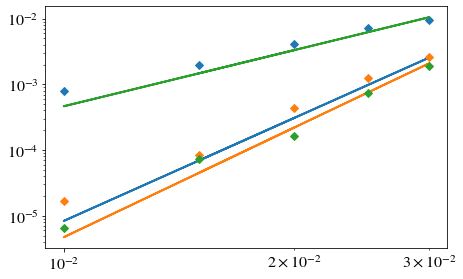

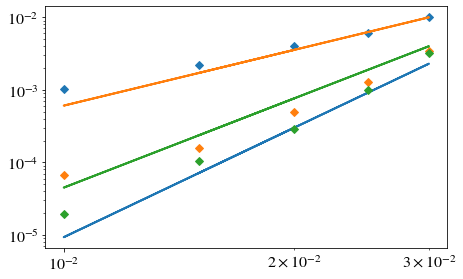

In [33]:
eval_code_list = [hgp_n225, hgp_n625, hgp_n1600]
eval_p_list = np.linspace(1e-2, 3e-2, 5)
num_samples = 800

sweep_num_round_list = [15, 20]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

## Lifted product code

Time elapsed: 138.17796921730042
A: 7.4155998065641215 p_c: 0.196089472241948
Time elapsed: 152.37994194030762
A: 0.05892893360391647 p_c: 0.06960495480459224
Time elapsed: 184.2253110408783
A: 0.004334692782234088 p_c: 0.04645124620139757
Time elapsed: 198.5784797668457
A: 0.0021230014100349966 p_c: 0.04066248407349249


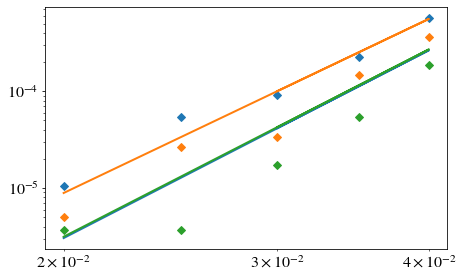

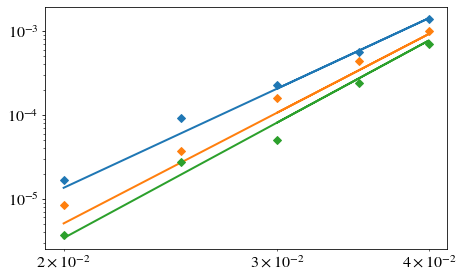

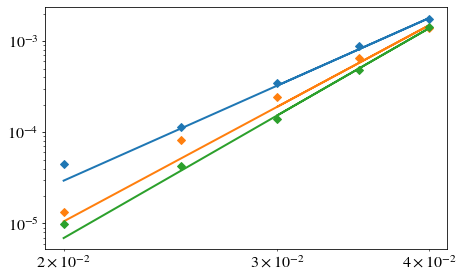

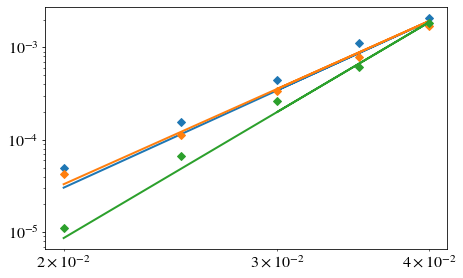

In [37]:
eval_code_list = [LP_code1, LP_code2, LP_code3]
eval_p_list = np.linspace(2e-2, 4e-2, 5)
num_samples = 2000

sweep_num_round_list = [3, 6, 10, 15]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyPhenlThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

Text(0.5, 1.0, 'LP, Phenomenological noise')

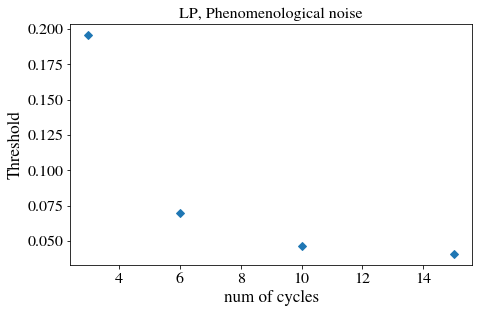

In [39]:
plt.figure()
plt.plot(sweep_num_round_list, sweep_threshold_list, 'D')
plt.xlabel('num of cycles')
plt.ylabel('Threshold')
plt.title('LP, Phenomenological noise')

# Circuit threshold

## HGP codes

Time elapsed: 374.9030010700226
A: 2.607470726415828 p_c: 0.039165328466209404
Time elapsed: 342.1005039215088
A: 0.20396998744780603 p_c: 0.013375904573472767


/Users/qian/anaconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


Time elapsed: 318.1738691329956
A: 0.0500725646392501 p_c: 0.007208352633962485
Time elapsed: 298.2047691345215
A: 0.04771188633062757 p_c: 0.006898099693351126
Time elapsed: 285.0438482761383
A: 0.041076142476304804 p_c: 0.006276486769153436


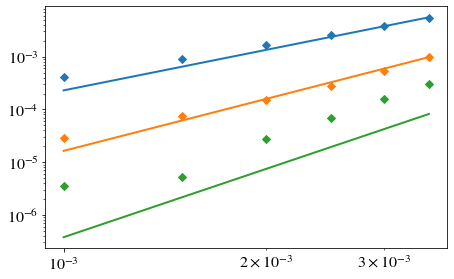

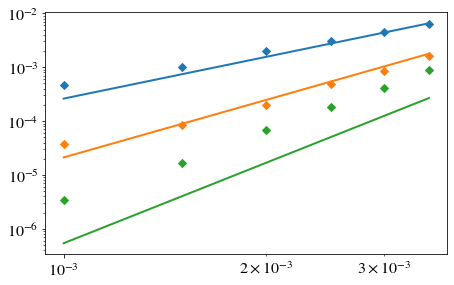

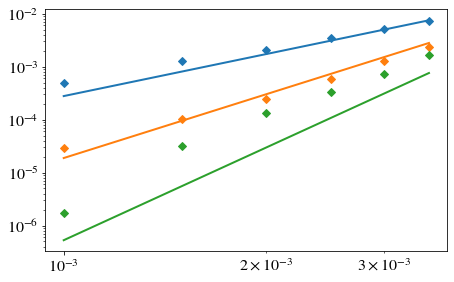

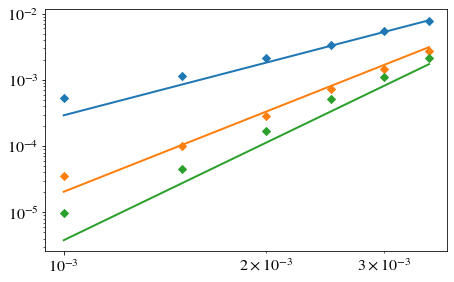

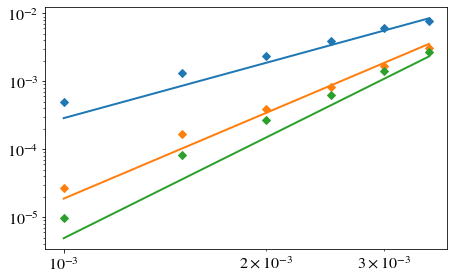

In [60]:
eval_code_list = [hgp_n225, hgp_n625, hgp_n1600]
eval_p_list = np.linspace(1e-3, 3.5e-3, 6)
num_samples = 6000

sweep_num_round_list = [3, 6, 10, 15, 20]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyCircuitThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

Text(0.5, 1.0, 'HGP, Circuit noise')

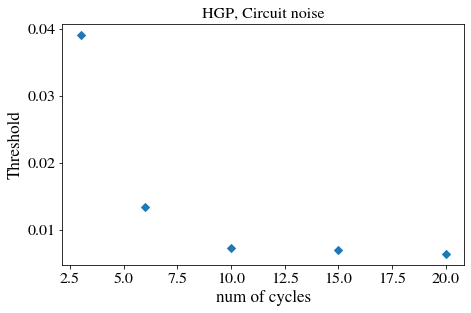

In [61]:
plt.figure()
plt.plot(sweep_num_round_list, sweep_threshold_list, 'D')
plt.xlabel('num of cycles')
plt.ylabel('Threshold')
plt.title('HGP, Circuit noise')

# LP codes

Time elapsed: 887.313238620758
A: 0.0047061630235219415 p_c: 0.008170500140427583


/Users/qian/anaconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


Time elapsed: 789.3218009471893
A: 0.005084707826870637 p_c: 0.005904843552835299
Time elapsed: 721.285902261734
A: 0.007385433526267532 p_c: 0.005807821456296285
Time elapsed: 636.5170269012451
A: 0.00929953616432007 p_c: 0.005913564529973872
Time elapsed: 584.6719512939453
A: 0.00924764730998057 p_c: 0.005833061276681567


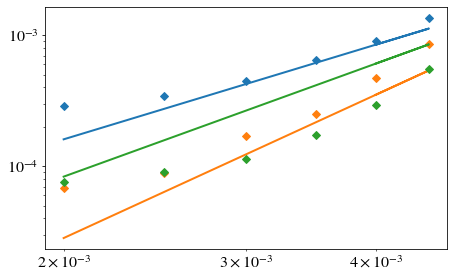

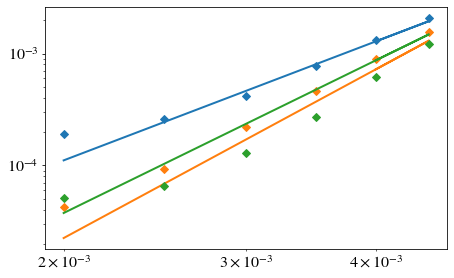

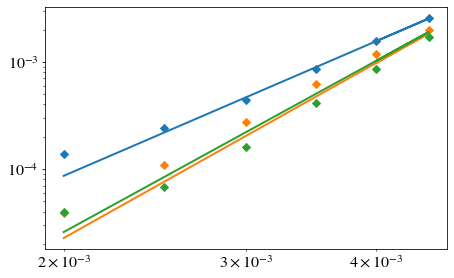

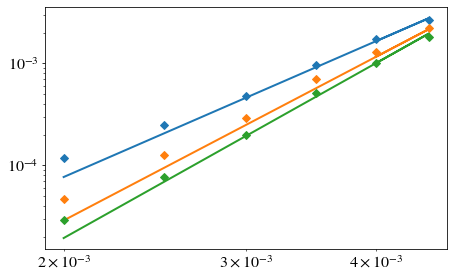

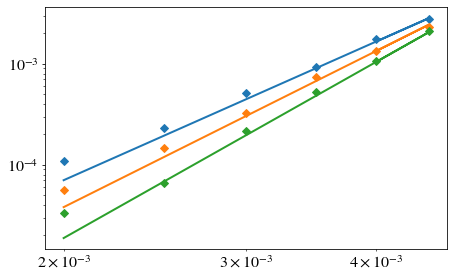

In [79]:
eval_code_list = [LP_code1, LP_code2, LP_code3]
eval_p_list = np.linspace(2e-3, 4.5e-3, 6)
num_samples = 10000

sweep_num_round_list = [3, 6, 10, 15, 20]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyCircuitThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

Text(0.5, 1.0, 'LP, Circuit noise')

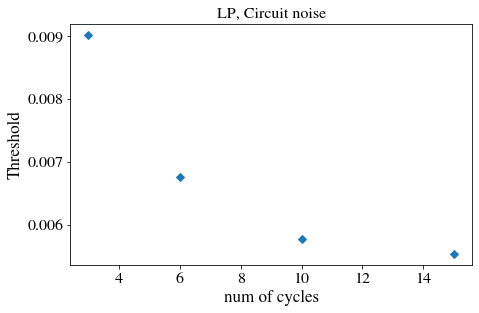

In [45]:
plt.figure()
plt.plot(sweep_num_round_list, sweep_threshold_list, 'D')
plt.xlabel('num of cycles')
plt.ylabel('Threshold')
plt.title('LP, Circuit noise')

## GBC codes

Time elapsed: 374.20399618148804
A: 0.008670612793301271 p_c: 0.010253090369405497


/Users/qian/anaconda2/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


Time elapsed: 270.4851670265198
A: 0.006944560639688916 p_c: 0.005878849070116124
Time elapsed: 218.21513295173645
A: 0.0077741972632476225 p_c: 0.005255011429180956
Time elapsed: 190.31270503997803
A: 0.00706431659768252 p_c: 0.004757431191604978
Time elapsed: 167.22059798240662
A: 0.005459770509701764 p_c: 0.004209382606443332
Time elapsed: 157.4668002128601
A: 0.004583086604900448 p_c: 0.0038698588843002657


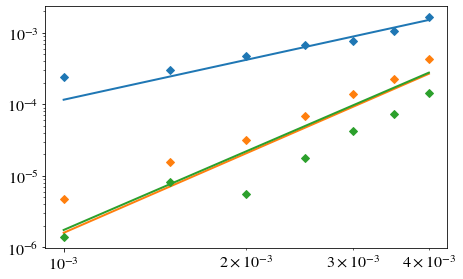

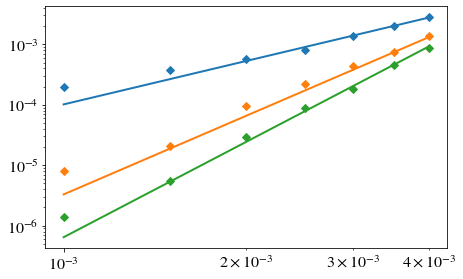

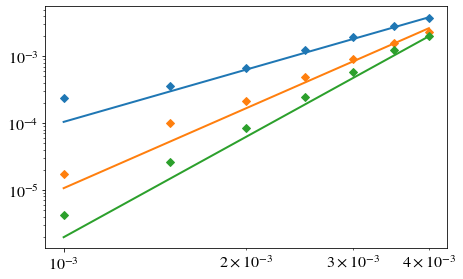

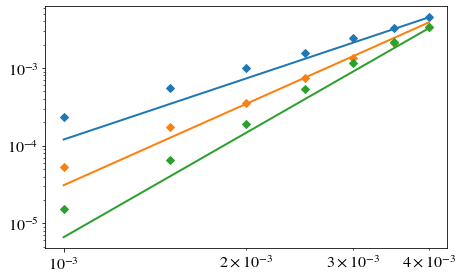

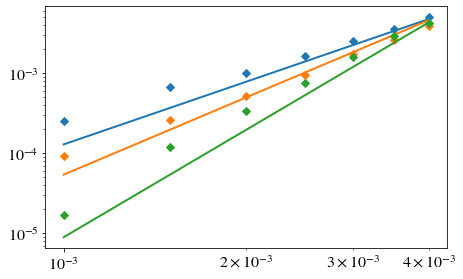

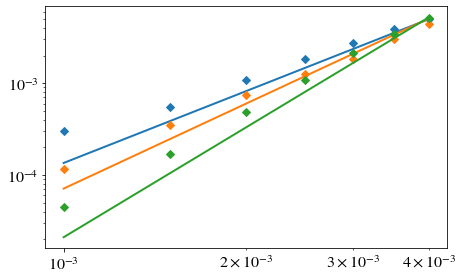

In [71]:
eval_code_list = [GBC_code1, GBC_code2, GBC_code3]
eval_p_list = np.linspace(1e-3, 4e-3, 7)
num_samples = 15000

sweep_num_round_list = [3, 6, 10, 15, 20, 25]
sweep_threshold_list = []
for sweep_num_round in sweep_num_round_list:
    sweep_threshold_list.append(CodeFamilyCircuitThreshold(eval_code_list, eval_p_list, sweep_num_round, int(num_samples*3/sweep_num_round), if_plot=True))

(0.0001, 0.012)

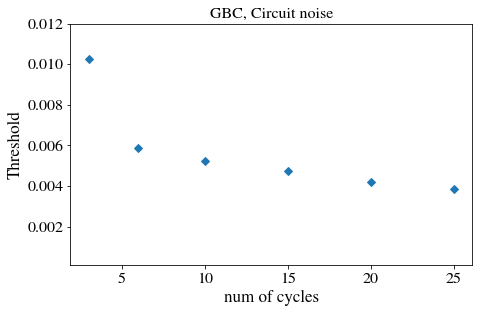

In [76]:
plt.figure()
plt.plot(sweep_num_round_list, sweep_threshold_list, 'D')
plt.xlabel('num of cycles')
plt.ylabel('Threshold')
plt.title('GBC, Circuit noise')
plt.ylim([1e-4, 1.2e-2])